In [61]:
# Battery Module Replacement Policies for AMRs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

In [62]:
# ------------------------------
# Constants
# ------------------------------
BATTERY_COST = 85.0
DOWNTIME_COST_PER_MIN = 12.0
TECH_LABOUR_PER_HOUR = 35.0

SWAP_TIME_1 = 15   # replace 1 module
SWAP_TIME_3 = 32   # replace 3 modules

# Technician arrival distribution
ARRIVAL_DELAYS = np.array([10, 20, 35])
ARRIVAL_PROBS  = np.array([0.55, 0.30, 0.15])

# Simulation design
INCIDENTS_PER_REP = 50
REPLICATIONS = 5000

np.random.seed(42)  # reproducibility

In [63]:
# ------------------------------
# Helper functions
# ------------------------------
def simulate_policy(replications, incidents_per_rep, swap_time, modules_replaced, downtime_cost_per_min):
    """
    Monte Carlo simulation for one policy
    """
    # Sample arrival delays
    delays = np.random.choice(ARRIVAL_DELAYS, size=(replications, incidents_per_rep), p=ARRIVAL_PROBS)

    # Downtime = arrival delay + swap time
    downtime = delays + swap_time

    # Cost per incident
    labour_per_incident = (swap_time / 60.0) * TECH_LABOUR_PER_HOUR
    parts_per_incident = modules_replaced * BATTERY_COST

    # Totals
    total_downtime = downtime.sum(axis=1)
    total_arrival = delays.sum(axis=1)

    labour_cost = labour_per_incident * incidents_per_rep
    parts_cost  = parts_per_incident * incidents_per_rep
    downtime_cost = total_downtime * downtime_cost_per_min

    total_cost = parts_cost + labour_cost + downtime_cost
    avg_downtime = total_downtime / incidents_per_rep
    prop_waiting = total_arrival / total_downtime

    return {
        "total_cost": total_cost,
        "parts_cost": np.repeat(parts_cost, replications),
        "labour_cost": np.repeat(labour_cost, replications),
        "downtime_cost": downtime_cost,
        "avg_downtime": avg_downtime,
        "prop_waiting": prop_waiting,
        "prop_repair": 1 - prop_waiting
    }

def ci_95(x):
    mean = np.mean(x)
    sd = np.std(x, ddof=1)
    se = sd / sqrt(len(x))
    z = 1.96
    return mean, mean - z*se, mean + z*se

def summarize(results, name):
    metrics = {
        "Total cost ($)": results["total_cost"],
        "Parts cost ($)": results["parts_cost"],
        "Labour cost ($)": results["labour_cost"],
        "Downtime cost ($)": results["downtime_cost"],
        "Avg downtime per incident (min)": results["avg_downtime"],
        "Proportion waiting": results["prop_waiting"],
        "Proportion repairing": results["prop_repair"]
    }
    rows = []
    for label, values in metrics.items():
        mean, lo, hi = ci_95(values)
        rows.append([name, label, round(mean, 2), round(lo, 2), round(hi, 2)])
    return pd.DataFrame(rows, columns=["Policy", "Metric", "Mean", "95% CI Low", "95% CI High"])

In [64]:
# ------------------------------
# (b) Base-case simulation
# ------------------------------
current = simulate_policy(REPLICATIONS, INCIDENTS_PER_REP, SWAP_TIME_1, 1, DOWNTIME_COST_PER_MIN)
bundled = simulate_policy(REPLICATIONS, INCIDENTS_PER_REP, SWAP_TIME_3, 3, DOWNTIME_COST_PER_MIN)

summary_current = summarize(current, "Current (replace 1)")
summary_bundled = summarize(bundled, "Bundled (replace 3)")
summary = pd.concat([summary_current, summary_bundled])

print("=== Base-case Results (downtime $12/min) ===")
summary.head(15)

=== Base-case Results (downtime $12/min) ===


,Policy,Metric,Mean,95% CI Low,95% CI High
0,Current (replace 1),Total cost ($),23748.24,23727.32,23769.16
1,Current (replace 1),Parts cost ($),4250.00,4250.00,4250.00
2,Current (replace 1),Labour cost ($),437.50,437.50,437.50
3,Current (replace 1),Downtime cost ($),19060.74,19039.82,19081.66
4,Current (replace 1),Avg downtime per incident (min),31.77,31.73,31.80
5,Current (replace 1),Proportion waiting,0.53,0.53,0.53
6,Current (replace 1),Proportion repairing,0.47,0.47,0.47
0,Bundled (replace 3),Total cost ($),42933.33,42912.22,42954.44
1,Bundled (replace 3),Parts cost ($),12750.00,12750.00,12750.00
2,Bundled (replace 3),Labour cost ($),933.33,933.33,933.33


In [65]:
# ------------------------------
# (c) Sensitivity analysis
# ------------------------------
print("\n=== Sensitivity (downtime $15/min) ===")
current_s = simulate_policy(REPLICATIONS, INCIDENTS_PER_REP, SWAP_TIME_1, 1, 15)
bundled_s = simulate_policy(REPLICATIONS, INCIDENTS_PER_REP, SWAP_TIME_3, 3, 15)

summary_s = pd.concat([
    summarize(current_s, "Current (replace 1) – Sensitivity"),
    summarize(bundled_s, "Bundled (replace 3) – Sensitivity")
])
summary_s.head(15)


=== Sensitivity (downtime $15/min) ===


,Policy,Metric,Mean,95% CI Low,95% CI High
0,Current (replace 1) – Sensitivity,Total cost ($),28492.02,28465.80,28518.24
1,Current (replace 1) – Sensitivity,Parts cost ($),4250.00,4250.00,4250.00
2,Current (replace 1) – Sensitivity,Labour cost ($),437.50,437.50,437.50
3,Current (replace 1) – Sensitivity,Downtime cost ($),23804.52,23778.30,23830.74
4,Current (replace 1) – Sensitivity,Avg downtime per incident (min),31.74,31.70,31.77
5,Current (replace 1) – Sensitivity,Proportion waiting,0.53,0.53,0.53
6,Current (replace 1) – Sensitivity,Proportion repairing,0.47,0.47,0.47
0,Bundled (replace 3) – Sensitivity,Total cost ($),50262.96,50237.20,50288.73
1,Bundled (replace 3) – Sensitivity,Parts cost ($),12750.00,12750.00,12750.00
2,Bundled (replace 3) – Sensitivity,Labour cost ($),933.33,933.33,933.33


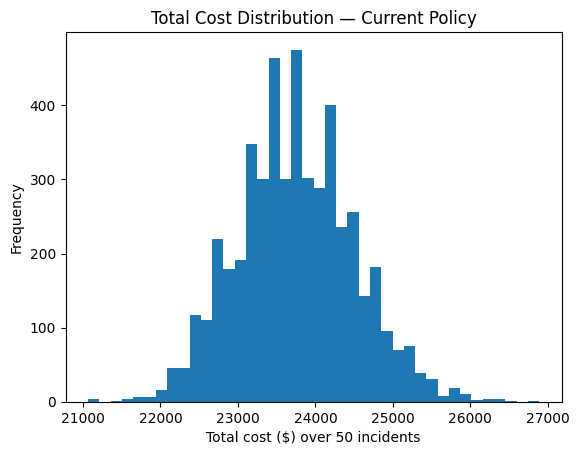

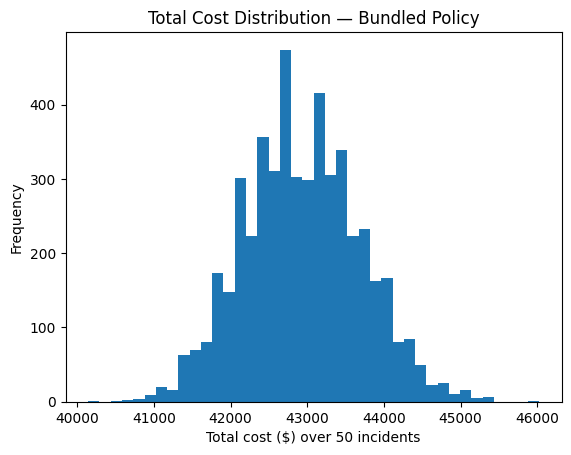

/tmp/ipython-input-3533068212.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([current["total_cost"], bundled["total_cost"]], labels=["Current", "Bundled"])


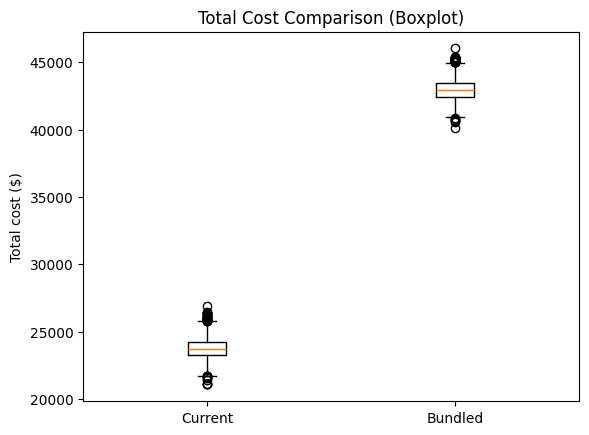

In [66]:
# ------------------------------
# (d) Visualization
# ------------------------------
plt.figure()
plt.hist(current["total_cost"], bins=40)
plt.title("Total Cost Distribution — Current Policy")
plt.xlabel("Total cost ($) over 50 incidents")
plt.ylabel("Frequency")
plt.show()

plt.figure()
plt.hist(bundled["total_cost"], bins=40)
plt.title("Total Cost Distribution — Bundled Policy")
plt.xlabel("Total cost ($) over 50 incidents")
plt.ylabel("Frequency")
plt.show()

plt.figure()
plt.boxplot([current["total_cost"], bundled["total_cost"]], labels=["Current", "Bundled"])
plt.title("Total Cost Comparison (Boxplot)")
plt.ylabel("Total cost ($)")
plt.show()

In [67]:
# ------------------------------
# (e) Executive Summary
# ------------------------------
mean_c, lo_c, hi_c = ci_95(current["total_cost"])
mean_b, lo_b, hi_b = ci_95(bundled["total_cost"])

print("\n=== Executive Summary ===")
print(f"Expected total cost is lower under the Current policy.")
print(f"Current policy: ${mean_c:,.0f} [{lo_c:,.0f}, {hi_c:,.0f}]")
print(f"Bundled policy: ${mean_b:,.0f} [{lo_b:,.0f}, {hi_b:,.0f}]")


=== Executive Summary ===
Expected total cost is lower under the Current policy.
Current policy: $23,748 [23,727, 23,769]
Bundled policy: $42,933 [42,912, 42,954]


In [68]:
# ------------------------------
# (f) Reflection
# ------------------------------
print("\n=== Reflection ===")
print("We assumed incidents are independent. In reality, battery module lifetimes overlap, so failures are correlated.")
print("A more detailed simulation could use the lifetime distribution to schedule failures over operating time.")


=== Reflection ===
We assumed incidents are independent. In reality, battery module lifetimes overlap, so failures are correlated.
A more detailed simulation could use the lifetime distribution to schedule failures over operating time.
